In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from scipy.signal import lfilter
from scipy import signal
import scipy
import math
from iir_biquad import iir_biquad as iir_biquad_patrick
from iir_biquad import test as test_patrick
from IIRSim import *
from iir_biquad import iir_biquad as patrick_biquad
from iir_biquad import test as patrick_test
from FrequencyResponse import *
from FPGATestIO import *

# lfilter vs Patrick's IIR

## Individual Cases

a=[ 1.         -1.25389411  0.68728096]
b=[ 0.84364048 -1.25389411  0.84364048]
a_fixed=[ 16384 -20544  11260]
b_fixed=[ 13822 -20544  13822]


<Figure size 640x480 with 0 Axes>

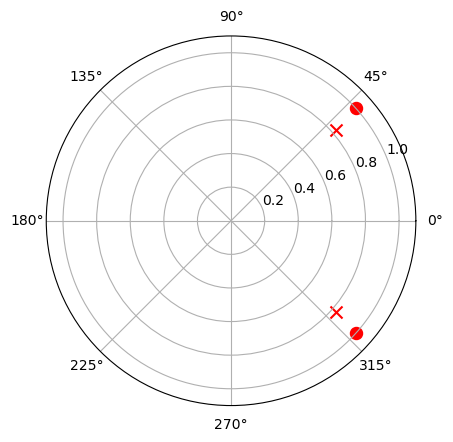

In [2]:
ADDED_PRECISION=0

b, a = signal.iirnotch(350, 2, 3000)
pole = signal.tf2zpk(b,a)[1][0]
zero = signal.tf2zpk(b,a)[0][0]
pmag=np.abs(pole)
pangle=np.angle(pole)
zmag=np.abs(zero)
zangle=np.angle(zero)

print("a=%s"%a)
print("b=%s"%b)

# Get the coefficients for the quantized biquad
coeffs = iir_biquad_coeffs(pmag, pangle)
coeffs_fixed_point = np.zeros(len(coeffs), dtype=np.int64)
coeffs_fixed_point_signed = np.zeros(len(coeffs), dtype=np.int64)
b_fixed_point_signed = np.zeros(len(b))
a_fixed_point_signed = np.zeros(len(a))

coeffs_fixed_point_extended = np.zeros(len(coeffs), dtype=np.int64)
coeffs_fixed_point_signed_extended = np.zeros(len(coeffs), dtype=np.int64)
b_fixed_point_signed_extended = np.zeros(len(b))
a_fixed_point_signed_extended = np.zeros(len(a))

## Usual Fixed Point
# For transfer function numerator
for i in range(len(b)):
    b_fixed_point_signed[i] = np.floor(b[i] * (2**14))
b_fixed_point_signed = np.array(b_fixed_point_signed, dtype=np.int64)
# Just in case we want to compare these later
# For transfer function denominator, after look-ahead
for i in range(len(a)):
    a_fixed_point_signed[i] = np.floor(a[i] * (2**14))
a_fixed_point_signed = np.array(a_fixed_point_signed, dtype=np.int64)
#  For clustered look-ahead
for i in range(len(coeffs_fixed_point)):
    # Coefficients are in Q4.14, where the sign bit IS counted
    coeffs_fixed_point_signed[i] = np.floor(coeffs[i] * (2**14))

coeffs_fixed_point_signed = np.array(coeffs_fixed_point_signed, dtype=np.int64)

## Extended Fixed Point
# For transfer function numerator
for i in range(len(b)):
    b_fixed_point_signed_extended[i] = np.floor(b[i] * (2**(14+ADDED_PRECISION)))
# Just in case we want to compare these later
# For transfer function denominator, after look-ahead
for i in range(len(a)):
    a_fixed_point_signed_extended[i] = np.floor(a[i] * (2**(14+ADDED_PRECISION)))
#  For clustered look-ahead
for i in range(len(coeffs_fixed_point)):
    # Coefficients are in Q4.14, where the sign bit IS counted
    coeffs_fixed_point_signed_extended[i] = np.floor(coeffs[i] * (2**(14+ADDED_PRECISION)))

print("a_fixed=%s"%a_fixed_point_signed )
print("b_fixed=%s"%b_fixed_point_signed )

plot_filter_polezero(zmag, zangle, pmag, pangle)

In [3]:
pulse_from_file = import_data("001_files/inputs/pulse_input_height_1024_clipped.dat")


****


****



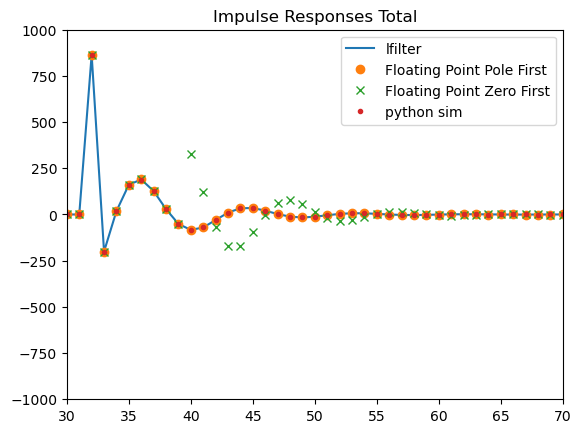

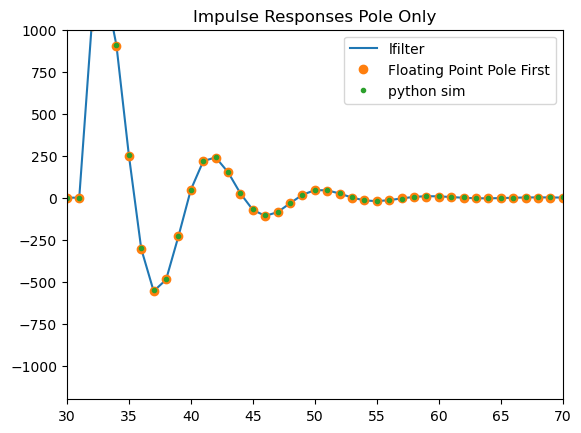

863.8878508040259
863


In [16]:
DEBUG=0
pulse_from_file_FIR = lfilter(b,[1],pulse_from_file.copy())
lfilter_data_zero_first = lfilter([1],a,np.array(pulse_from_file_FIR))#lfilter(b,a,np.array(pulse_from_file))



pulse_from_file_IIR = lfilter([1],a,pulse_from_file.copy())
lfilter_data_pole_first = lfilter(b,[1],np.array(pulse_from_file_FIR))#lfilter(b,a,np.array(pulse_from_file))

lfilter_data = lfilter(b,a,pulse_from_file.copy())#lfilter(b,a,np.array(pulse_from_file))

patrick_data = lfilter(b,[1],patrick_biquad(pulse_from_file.copy(), 8, pmag, pangle, ics = None, debug=DEBUG).copy())
patrick_data_reversed = patrick_biquad(lfilter(b,[1],pulse_from_file.copy()).copy(), 8, pmag, pangle, ics = None, debug=DEBUG)

patrick_IIR = patrick_biquad(pulse_from_file.copy(), 8, pmag, pangle, ics = None, debug=DEBUG)

# patrick_data = patrick_biquad(pulse_from_file_FIR, 8, pmag, pangle, ics = None, debug=1)

# patrick_data_reverse = patrick_biquad(pulse_from_file, 8, pmag, pangle, ics = None, debug=1)
# patrick_data_reverse = lfilter(b,[1],patrick_data_reverse)


print("\n****\n")
# The "a"s being used are not quantized, they are processed as floating point
python_data_IIR = iir_biquad_run_fixed_point(pulse_from_file.copy(), coeffs_fixed_point_signed, 
                                         decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) 
python_data = np.right_shift(np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],python_data_IIR.copy())),dtype=np.int64),14)
print("\n****\n")
# # Apply the numerator with lfilter, the rest of the "junk" is correcting for multiplying a fixed point value
# values_with_FIR_extended = np.right_shift(np.array(np.round(signal.lfilter(b_fixed_point_signed_extended, [1], pulse_from_file)),dtype=np.int64),
#                                           14+ADDED_PRECISION)
# The "a"s being used are not quantized, they are processed as floating point
# python_data_extended = iir_biquad_run_fixed_point_extended(pulse_from_file.copy(), coeffs_fixed_point_signed_extended, 
#                                                              decimate=True, a1=a[1], a2=a[0],debug=DEBUG, added_precision=ADDED_PRECISION) 
# python_data_extended = lfilter(b,[1],python_data_extended.copy())

# print("\n****\n")
# # Apply the numerator with lfilter, the rest of the "junk" is correcting for multiplying a fixed point value
# values_with_FIR = np.right_shift(np.array(np.round(signal.lfilter(b_fixed_point_signed, [1], pulse_from_file)),dtype=np.int64),14)
# # The "a"s being used are not quantized, they are processed as floating point
# python_data = iir_biquad_run_fixed_point(np.array(values_with_FIR), coeffs_fixed_point_signed, 
#                                          decimate=True, a1=a[1], a2=a[0],debug=1) 

# print("\n****\n")
# # Apply the numerator with lfilter, the rest of the "junk" is correcting for multiplying a fixed point value
# values_with_FIR_extended = np.right_shift(np.array(np.round(signal.lfilter(b_fixed_point_signed_extended, [1], pulse_from_file)),dtype=np.int64),
#                                           14+ADDED_PRECISION)
# # The "a"s being used are not quantized, they are processed as floating point
# python_data_extended = iir_biquad_run_fixed_point_extended(np.array(values_with_FIR_extended), coeffs_fixed_point_signed_extended, 
#                                                              decimate=True, a1=a[1], a2=a[0],debug=1, added_precision=ADDED_PRECISION) 

# plt.plot(range(len(pulse_from_file)), lfilter_data_reversed, label="lfilter Pole First", linestyle="--")
plt.plot(range(len(pulse_from_file)), lfilter_data, label="lfilter", linestyle="-")

plt.plot(range(len(pulse_from_file)), patrick_data, label="Floating Point Pole First", marker="o", linestyle="None")
plt.plot(range(len(pulse_from_file)), patrick_data_reversed, label="Floating Point Zero First", marker="x", linestyle="None")

# plt.plot(range(len(pulse_from_file)), patrick_data_combined, label="Patrick Sim Combined", marker="x")
# plt.plot(range(len(pulse_from_file)), lfilter_data_reversed, label="lfilter Pole First", linestyle=":")
# plt.plot(range(len(pulse_from_file)), python_data, label="python sim", linestyle="None", marker="o")
plt.plot(range(len(pulse_from_file)), python_data, label="python sim", linestyle="None", marker=".")
plt.legend()
plt.title("Impulse Responses Total")
plt.xlim(30,70)
plt.ylim(-1000,1000)
plt.show()


plt.plot(range(len(pulse_from_file)), pulse_from_file_IIR, label="lfilter", linestyle="-")

plt.plot(range(len(pulse_from_file)), patrick_IIR, label="Floating Point Pole First", marker="o", linestyle="None")
# plt.plot(range(len(pulse_from_file)), patrick_data_reversed, label="Floating Point Zero First", marker="x", linestyle="None")

# plt.plot(range(len(pulse_from_file)), patrick_data_combined, label="Patrick Sim Combined", marker="x")
# plt.plot(range(len(pulse_from_file)), lfilter_data_reversed, label="lfilter Pole First", linestyle=":")
# plt.plot(range(len(pulse_from_file)), python_data, label="python sim", linestyle="None", marker="o")
plt.plot(range(len(pulse_from_file)), python_data_IIR, label="python sim", linestyle="None", marker=".")
plt.legend()
plt.title("Impulse Responses Pole Only")
plt.xlim(30,70)
plt.ylim(-1200,1000)
plt.show()
print(lfilter_data[32])
print(python_data[32])

# plt.plot(range(len(pulse_from_file)), np.subtract(patrick_data,lfilter_data ), label="simulation difference")
# plt.title("Patrick Tone Response Difference")
# plt.show()

# plt.plot(range(len(pulse_from_file)), np.subtract(python_data,lfilter_data ), label="python simulation difference")
# plt.title("Python Tone Response Difference")
# plt.legend()
# plt.xlim(0,500)
# plt.title("Impulse Responses")
# plt.show()

# plt.plot(range(len(pulse_from_file)), np.subtract(patrick_data,lfilter_data ), label="patrick simulation difference")
# plt.title("Impulse Response Difference")
# plt.xlim(0,500)
# plt.show()


# plt.plot(range(len(pulse_from_file)), np.subtract(patrick_data,python_data ), label="both simulation difference")
# plt.title("Impulse Response Difference")
# plt.xlim(0,500)
# plt.show()

In [17]:
tone_from_file = import_data("001_files/inputs/input_200_MHz_4_zpclocks_hanning.dat")

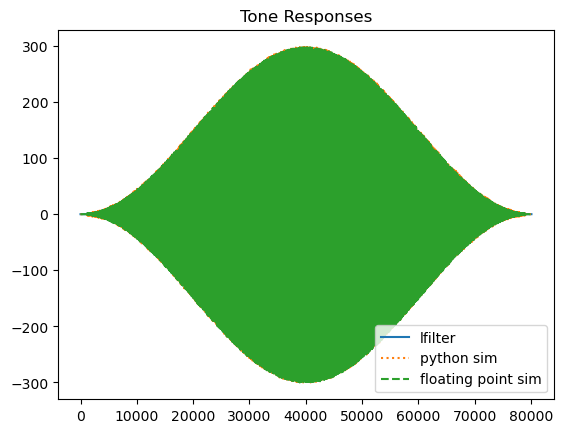

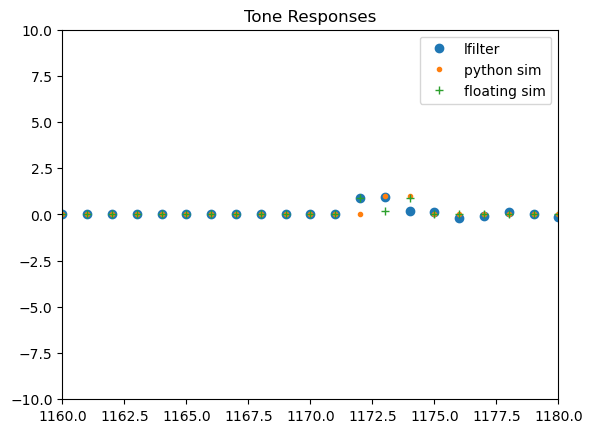

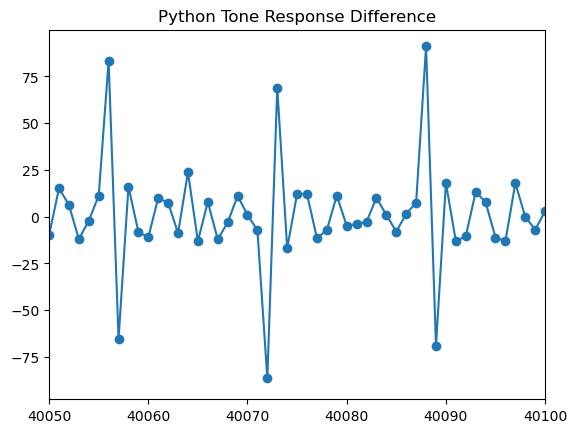

In [58]:
# patrick_data = lfilter(b,[1],patrick_biquad(tone_from_file, 8, pmag, pangle, ics = None))
# lfilter_data = lfilter(b,a,np.array(tone_from_file))

lfilter_data = lfilter(b,a,tone_from_file.copy())#lfilter(b,a,np.array(pulse_from_file))

# The "a"s being used are not quantized, they are processed as floating point

patrick_data = lfilter(b,[1],patrick_biquad(tone_from_file.copy(), 8, pmag, pangle, ics = None, debug=DEBUG).copy())

python_data_IIR = iir_biquad_run_fixed_point(tone_from_file.copy(), coeffs_fixed_point_signed, 
                                         decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) 
python_data = np.right_shift(np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],python_data_IIR.copy())),dtype=np.int64),14)

# # Apply the numerator with lfilter, the rest of the "junk" is correcting for multiplying a fixed point value
# values_with_FIR = np.right_shift(np.array(np.round(signal.lfilter(b_fixed_point_signed, [1], tone_from_file)),dtype=np.int64),14)

# # The "a"s being used are not quantized, they are processed as floating point
# python_data = iir_biquad_run_fixed_point(np.array(values_with_FIR), coeffs_fixed_point_signed, 
#                                          decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=0) 

# plt.plot(range(len(tone_from_file)), patrick_data, label="Patrick Sim")
plt.plot(range(len(tone_from_file)), lfilter_data, label="lfilter", linestyle="-")
plt.plot(range(len(tone_from_file)), python_data, label="python sim", linestyle=":")
plt.plot(range(len(tone_from_file)), patrick_data, label="floating point sim", linestyle="--")
plt.legend()
plt.title("Tone Responses")
# plt.xlim(40000,40100)
plt.show()

plt.plot(range(len(tone_from_file)), lfilter_data, label="lfilter", linestyle="None", marker="o")
plt.plot(range(len(tone_from_file)), python_data, label="python sim", linestyle="None", marker=".")
plt.plot(range(len(tone_from_file)), patrick_data, label="floating sim", linestyle="None", marker="+")
plt.legend()
plt.title("Tone Responses")
# plt.xlim(40050,40100)
plt.xlim(1160,1180)
plt.ylim(-10,10)
plt.show()

# plt.plot(range(len(pulse_from_file)), np.subtract(patrick_data,lfilter_data ), label="simulation difference")
# plt.title("Patrick Tone Response Difference")
# plt.show()

plt.plot(range(len(tone_from_file)), np.subtract(python_data,lfilter_data ), label="simulation difference", marker="o")
plt.title("Python Tone Response Difference")
plt.xlim(40050,40100)
plt.show()

In [31]:
gauss_from_file = import_data("001_files/inputs/gauss_input_400_sigma_hanning_clipped_0.dat")

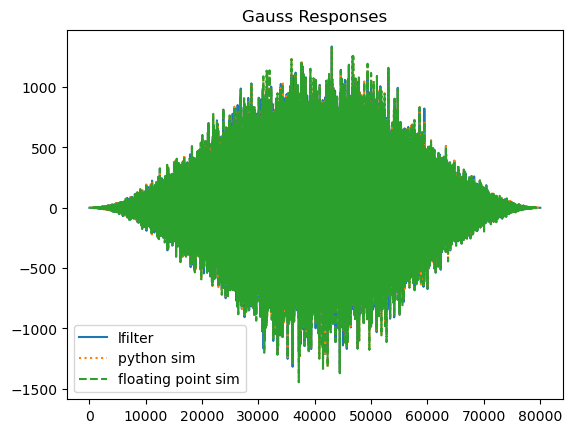

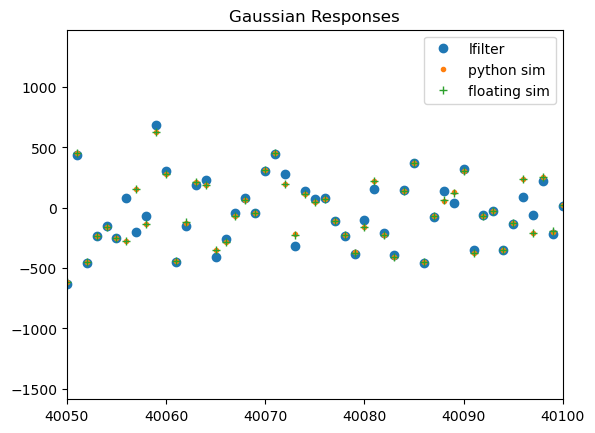

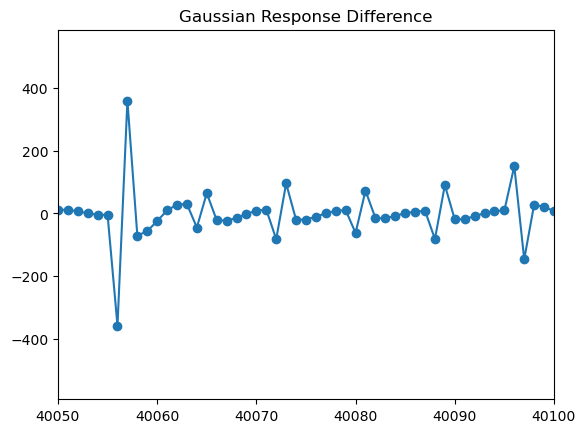

In [33]:
# patrick_data = lfilter(b,[1],patrick_biquad(gauss_from_file, 8, pmag, pangle, ics = None))
# lfilter_data = lfilter(b,a,np.array(gauss_from_file))

lfilter_data = lfilter(b,a,gauss_from_file.copy())#lfilter(b,a,np.array(pulse_from_file))

# The "a"s being used are not quantized, they are processed as floating point

patrick_data = lfilter(b,[1],patrick_biquad(gauss_from_file.copy(), 8, pmag, pangle, ics = None, debug=DEBUG).copy())

python_data_IIR = iir_biquad_run_fixed_point(gauss_from_file.copy(), coeffs_fixed_point_signed, 
                                         decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) 
python_data = np.right_shift(np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],python_data_IIR.copy())),dtype=np.int64),14)

# # Apply the numerator with lfilter, the rest of the "junk" is correcting for multiplying a fixed point value
# values_with_FIR = np.right_shift(np.array(np.round(signal.lfilter(b_fixed_point_signed, [1], gauss_from_file)),dtype=np.int64),14)

# # The "a"s being used are not quantized, they are processed as floating point
# python_data = iir_biquad_run_fixed_point(np.array(values_with_FIR), coeffs_fixed_point_signed, 
#                                          decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=0) 

# plt.plot(range(len(gauss_from_file)), patrick_data, label="Patrick Sim")
plt.plot(range(len(gauss_from_file)), lfilter_data, label="lfilter", linestyle="-")
plt.plot(range(len(gauss_from_file)), python_data, label="python sim", linestyle=":")
plt.plot(range(len(gauss_from_file)), patrick_data, label="floating point sim", linestyle="--")
plt.legend()
plt.title("Gauss Responses")
# plt.xlim(40000,40100)
plt.show()

plt.plot(range(len(gauss_from_file)), lfilter_data, label="lfilter", linestyle="None", marker="o")
plt.plot(range(len(gauss_from_file)), python_data, label="python sim", linestyle="None", marker=".")
plt.plot(range(len(gauss_from_file)), patrick_data, label="floating sim", linestyle="None", marker="+")
plt.legend()
plt.title("Gaussian Responses")
plt.xlim(40050,40100)
plt.show()

# plt.plot(range(len(pulse_from_file)), np.subtract(patrick_data,lfilter_data ), label="simulation difference")
# plt.title("Patrick gauss Response Difference")
# plt.show()

plt.plot(range(len(gauss_from_file)), np.subtract(python_data,lfilter_data), label="simulation difference", marker="o")
plt.title("Gaussian Response Difference")
plt.xlim(40050,40100)
plt.show()

## Frequency Response Using Gaussians

In [39]:
fft_input_result = {}
fft_patrick_result = {}
fft_lfilter_result = {}
fft_python_result = {}

In [41]:
TRIALS = 100
NOTCH = 800
Q = 8

# Get the parameters of the notch
b, a = signal.iirnotch(NOTCH, Q, 3000)
pole = signal.tf2zpk(b,a)[1][0]
zero = signal.tf2zpk(b,a)[0][0]
pmag=np.abs(pole)
pangle=np.angle(pole)
zmag=np.abs(zero)
zangle=np.angle(zero)

# Get the coefficients for the quantized biquad
coeffs = iir_biquad_coeffs(pmag, pangle)
coeffs_fixed_point = np.zeros(len(coeffs), dtype=np.int64)
coeffs_fixed_point_signed = np.zeros(len(coeffs), dtype=np.int64)
b_fixed_point_signed = np.zeros(len(b))
a_fixed_point_signed = np.zeros(len(a))

## Usual Fixed Point
# For transfer function numerator
for i in range(len(b)):
    b_fixed_point_signed[i] = np.floor(b[i] * (2**14))
b_fixed_point_signed = np.array(b_fixed_point_signed, dtype=np.int64)
# Just in case we want to compare these later
# For transfer function denominator, after look-ahead
for i in range(len(a)):
    a_fixed_point_signed[i] = np.floor(a[i] * (2**14))
a_fixed_point_signed = np.array(a_fixed_point_signed, dtype=np.int64)
#  For clustered look-ahead
for i in range(len(coeffs_fixed_point)):
    # Coefficients are in Q4.14, where the sign bit IS counted
    coeffs_fixed_point_signed[i] = np.floor(coeffs[i] * (2**14))

coeffs_fixed_point_signed = np.array(coeffs_fixed_point_signed, dtype=np.int64)

# Import the Gaussian input data once to get the lengths
data_len = len(import_data("001_files/inputs/gauss_input_400_sigma_hanning_clipped_%d.dat"%0))
fft_input_results = np.zeros((TRIALS, data_len))     
fft_patrick_results = np.zeros((TRIALS, data_len))     
fft_python_results = np.zeros((TRIALS, data_len))   
fft_lfilter_results = np.zeros((TRIALS, data_len))

# Run the trials on the data
for i in range(TRIALS):
    # Import the trial inputs
    gauss_samps = import_data("001_files/inputs/gauss_input_400_sigma_hanning_clipped_%d.dat"%i)

    # Run the filters on the trials
    patrick_data = lfilter(b,[1],patrick_biquad(gauss_samps.copy(), 8, pmag, pangle, ics = None))
    lfilter_data = lfilter(b,a,gauss_samps)

    python_data_IIR = iir_biquad_run_fixed_point(gauss_samps.copy(), coeffs_fixed_point_signed, 
                                         decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) 
    python_data = np.right_shift(np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],python_data_IIR.copy())),dtype=np.int64),14)

    # # The "a"s being used are not quantized, they are processed as floating point
    # python_data_iir = iir_biquad_run_fixed_point(gauss_samps.copy(), coeffs_fixed_point_signed, 
    #                                          decimate=False, a1=a[1], a2=a[2],debug=0) 

    
    # # Apply the numerator with lfilter, the rest of the "junk" is correcting for multiplying a fixed point value
    # python_data = np.right_shift(np.array(np.round(signal.lfilter(b_fixed_point_signed, [1], python_data_iir)),dtype=np.int64),14)
    
    fft_input_results[i] = np.abs(np.fft.fft(gauss_samps))**2   
    fft_patrick_results[i] = np.abs(np.fft.fft(patrick_data))**2
    fft_lfilter_results[i] = np.abs(np.fft.fft(lfilter_data))**2
    fft_python_results[i] = np.abs(np.fft.fft(python_data))**2
    if(i%10 == 0):
        print(i)
fft_input_result[NOTCH] = np.mean(fft_input_results, axis=0)
fft_patrick_result[NOTCH] = np.mean(fft_patrick_results, axis=0)
fft_lfilter_result[NOTCH] = np.mean(fft_lfilter_results, axis=0)
fft_python_result[NOTCH] = np.mean(fft_python_results, axis=0)

0
10
20
30
40
50
60
70
80
90


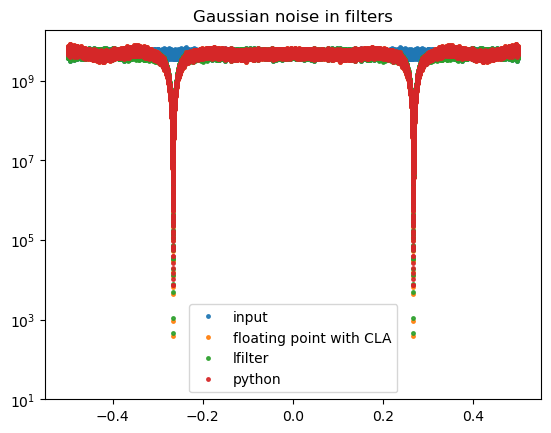

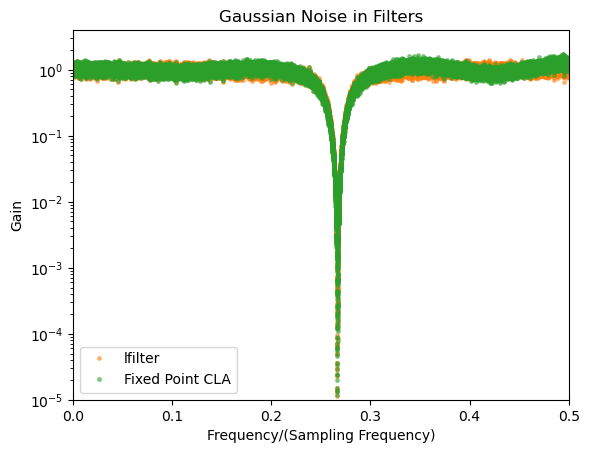

In [50]:
plot_notch_freq = 800
plt.plot(np.fft.fftfreq(len(fft_input_result[plot_notch_freq])),np.abs(fft_input_result[plot_notch_freq]), linestyle="None", 
         marker=".", label="input", markersize=5, alpha=0.9, color="C0")
plt.plot(np.fft.fftfreq(len(fft_patrick_result[plot_notch_freq])),np.abs(fft_patrick_result[plot_notch_freq]), linestyle="None", 
         marker=".", label="floating point with CLA", markersize=5, alpha=0.9, color="C1")
plt.plot(np.fft.fftfreq(len(fft_lfilter_result[plot_notch_freq])),np.abs(fft_lfilter_result[plot_notch_freq]), linestyle="None",
         marker=".", label="lfilter", markersize=5, alpha=0.9, color="C2")
plt.plot(np.fft.fftfreq(len(fft_python_result[plot_notch_freq])),np.abs(fft_python_result[plot_notch_freq]), linestyle="None",
         marker=".", label="python", markersize=5, alpha=0.9, color="C3")
plt.legend()
plt.yscale("log")
plt.gca().set_ylim(bottom=10**1)
plt.title("Gaussian noise in filters")
# plt.xlim(0,0.5)
# plt.savefig("GaussianNoiseOn%dMHzNotch.png"%plot_notch_freq)
plt.show()

mean_power = np.mean(fft_input_result[plot_notch_freq])


# plt.plot(np.fft.fftfreq(len(fft_patrick_result[plot_notch_freq])),np.abs(fft_patrick_result[plot_notch_freq])/mean_power, linestyle="None", 
#          marker=".", label="floating point with CLA", markersize=1, alpha=0.05, color="C1")
plt.plot(np.fft.fftfreq(len(fft_lfilter_result[plot_notch_freq])),np.abs(fft_lfilter_result[plot_notch_freq])/mean_power, linestyle="None",
         marker=".", label="lfilter", markersize=5, alpha=0.5, color="C1")
plt.plot(np.fft.fftfreq(len(fft_python_result[plot_notch_freq])),np.abs(fft_python_result[plot_notch_freq])/mean_power, linestyle="None",
         marker=".", label="Fixed Point CLA", markersize=5, alpha=0.5, color="C2")
plt.legend()
plt.yscale("log")
plt.gca().set_ylim(bottom=10**-5)
plt.title("Gaussian Noise in Filters")
plt.xlim(0,0.5)
plt.xlabel("Frequency/(Sampling Frequency)")
plt.ylabel("Gain")
# plt.savefig("GaussianNoiseOn%dMHzNotch.png"%plot_notch_freq)
plt.show()

## Extended Precision, rounding coeffs

In [ ]:
fft_input_result = {}
fft_patrick_result = {}
fft_lfilter_result = {}
fft_python_result = {}
TRIALS = 50
NOTCH = 750
Q = 1
ADDED_PRECISION=10

# Get the parameters of the notch
b, a = signal.iirnotch(NOTCH, Q, 3000)
pole = signal.tf2zpk(b,a)[1][0]
zero = signal.tf2zpk(b,a)[0][0]
pmag=np.abs(pole)
pangle=np.angle(pole)
zmag=np.abs(zero)
zangle=np.angle(zero)

# Get the coefficients for the quantized biquad
coeffs = iir_biquad_coeffs(pmag, pangle)
coeffs_fixed_point = np.zeros(len(coeffs), dtype=np.int64)
coeffs_fixed_point_signed = np.zeros(len(coeffs), dtype=np.int64)
b_fixed_point_signed = np.zeros(len(b))

# For transfer function numerator
for i in range(len(b)):
    b_fixed_point_signed[i] = np.array(np.floor(b[i] * (2**(14+ADDED_PRECISION))),dtype=np.int64)
# Just in case we want to compare these later
a_fixed_point_signed = np.zeros(len(a))
# For transfer function denominator, after look-ahead
for i in range(len(a)):
    a_fixed_point_signed[i] = np.array(np.floor(a[i] * (2**(14+ADDED_PRECISION))),dtype=np.int64)
#  For clustered look-ahead
for i in range(len(coeffs_fixed_point)):
    # Coefficients are in Q4.14, where the sign bit IS counted
    coeffs_fixed_point_signed[i] = np.array(np.floor(coeffs[i] * (2**(14+ADDED_PRECISION))),dtype=np.int64)

# Import the Gaussian input data once to get the lengths
data_len = len(import_data("001_files/inputs/gauss_input_400_sigma_hanning_clipped_%d.dat"%0))
fft_input_results = np.zeros((TRIALS, data_len))     
fft_patrick_results = np.zeros((TRIALS, data_len))     
fft_python_results = np.zeros((TRIALS, data_len))   
fft_lfilter_results = np.zeros((TRIALS, data_len))

# Run the trials on the data
for i in range(TRIALS):
    # Import the trial inputs
    gauss_samps = import_data("001_files/inputs/gauss_input_400_sigma_hanning_clipped_%d.dat"%i)

    # Run the filters on the trials
    patrick_data = lfilter(b,[1],patrick_biquad(gauss_samps, 8, pmag, pangle, ics = None))
    lfilter_data = lfilter(b,a,gauss_samps)

    # Apply the numerator with lfilter, the rest of the "junk" is correcting for multiplying a fixed point value
    values_with_FIR = np.right_shift(np.array(np.round(signal.lfilter(b_fixed_point_signed, [1], gauss_samps)),dtype=np.int64),(14+ADDED_PRECISION))

    # The "a"s being used are not quantized, they are processed as floating point
    python_data = iir_biquad_run_fixed_point_extended(np.array(values_with_FIR), coeffs_fixed_point_signed, 
                                             decimate=False, a1=a[1], a2=a[1],debug=0) 
    
    fft_input_results[i] = np.abs(np.fft.fft(gauss_samps))**2   
    fft_patrick_results[i] = np.abs(np.fft.fft(patrick_data))**2
    fft_lfilter_results[i] = np.abs(np.fft.fft(lfilter_data))**2
    fft_python_results[i] = np.abs(np.fft.fft(python_data))**2
    if(i%10 == 0):
        print(i)
fft_input_result[NOTCH] = np.mean(fft_input_results, axis=0)
fft_patrick_result[NOTCH] = np.mean(fft_patrick_results, axis=0)
fft_lfilter_result[NOTCH] = np.mean(fft_lfilter_results, axis=0)
fft_python_result[NOTCH] = np.mean(fft_python_results, axis=0)

In [ ]:
plot_notch_freq = 750
plt.plot(np.fft.fftfreq(len(fft_input_result[plot_notch_freq])),np.abs(fft_input_result[plot_notch_freq]), linestyle="None", 
         marker=".", label="input", markersize=5, alpha=0.9, color="C0")
plt.plot(np.fft.fftfreq(len(fft_patrick_result[plot_notch_freq])),np.abs(fft_patrick_result[plot_notch_freq]), linestyle="None", 
         marker=".", label="floating point with CLA", markersize=5, alpha=0.9, color="C1")
plt.plot(np.fft.fftfreq(len(fft_lfilter_result[plot_notch_freq])),np.abs(fft_lfilter_result[plot_notch_freq]), linestyle="None",
         marker=".", label="lfilter", markersize=5, alpha=0.9, color="C2")
plt.plot(np.fft.fftfreq(len(fft_python_result[plot_notch_freq])),np.abs(fft_python_result[plot_notch_freq]), linestyle="None",
         marker=".", label="python", markersize=5, alpha=0.9, color="C3")
plt.legend()
plt.yscale("log")
plt.gca().set_ylim(bottom=10**8)
plt.title("Gaussian noise in filters")
# plt.xlim(0,0.5)
# plt.savefig("GaussianNoiseOn%dMHzNotch.png"%plot_notch_freq)
plt.show()

mean_power = np.mean(fft_input_result[plot_notch_freq])


plt.plot(np.fft.fftfreq(len(fft_patrick_result[plot_notch_freq])),np.abs(fft_patrick_result[plot_notch_freq])/mean_power, linestyle="None", 
         marker=".", label="floating point with CLA", markersize=5, alpha=0.9, color="C1")
plt.plot(np.fft.fftfreq(len(fft_lfilter_result[plot_notch_freq])),np.abs(fft_lfilter_result[plot_notch_freq])/mean_power, linestyle="None",
         marker=".", label="lfilter", markersize=5, alpha=0.9, color="C2")
plt.plot(np.fft.fftfreq(len(fft_python_result[plot_notch_freq])),np.abs(fft_python_result[plot_notch_freq])/mean_power, linestyle="None",
         marker=".", label="python", markersize=5, alpha=0.9, color="C3")
plt.legend()
plt.yscale("log")
plt.gca().set_ylim(bottom=10**-5)
plt.title("Gaussian noise in filters")
plt.xlim(0,0.5)
plt.xlabel("Frequency/(Sampling Frequency)")
plt.ylabel("Gain")
# plt.savefig("GaussianNoiseOn%dMHzNotch.png"%plot_notch_freq)
plt.show()